# Timeseries
Our goal here is to identify the following features:
* trend or consistent non-periodic directional movement
* seasonal (periodic) variation
* residual stochastic variation (noise)

Trend and seasonal make a base for forcasting; noise adjusts our prediction confidence intervals.

In [ ]:
import os
import re
import numpy as np
import pandas as pd

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
features = pd.read_csv('data/features.csv')
features = features[(features['category'] == 'assault') & (features['year'] >= 2007)]
features.head()

,Unnamed: 0,stat,category,date,year,month,day,weekday,hour,city,zip,lng,lat,gang,violent,weapon,gun,knife
0,0,146,assault,2007-01-01,2007,1,1,0,0.416667,Whittier,90604,-117.993988,33.919049,0,1,0,0,0
2,2,144,assault,2007-01-01,2007,1,1,0,0.083333,Universal City,91608,-118.351299,34.136272,0,1,0,0,0
4,4,50,assault,2007-01-01,2007,1,1,0,1.539722,Rosemead,91770,-118.082102,34.040848,0,1,0,0,0
8,8,144,assault,2007-01-01,2007,1,1,0,1.333333,Newhall,91321,-118.536733,34.388553,0,1,0,0,0
9,9,54,assault,2007-01-01,2007,1,1,0,1.000000,Bellflower,90706,-118.126423,33.900948,0,1,0,0,0


We are going to focus on daily counts timeseries in this notebook.

In [3]:
timeseries = features\
    .groupby(['date','weapon']).size()\
    .reset_index(name = 'count')

In [4]:
# our local interactive visual with bookmarking capacity
from viz import local
viz = local.VizNotebook()

timeseries['date'] = timeseries['date'].apply(lambda x: str(x))
timeseries['weapon'] = timeseries['weapon'].apply(lambda x: str(x))

viz.static(timeseries.to_json(orient='records'), type = 'line', height = 350, width = '100%',
           x = 'date',
           y = 'count',
           z = 'weapon',
           labels = ['non-aggravated','aggravated'],
           colormap = {'0':'maroon', '1':'red'},
           title = 'Assault incidents daily count for 2007 - 2016 timeline')

In [5]:
index = pd.date_range(start = '2007-01-01', end = '2016-12-31')

# non-aggravated assault daily count timeseries
ts = features[features['weapon'] == 0].groupby(['date'], as_index = True).size()
ts.index = pd.DatetimeIndex(ts.index)
ts = ts.reindex(index, fill_value = 0)

# reserve the last year for testing
train, test = ts[:-365], ts[-365:]

### Stationarity
Stationarity means that the statistical properties (namely the mean and variance) of the series are constant in time. It that case we can use moving average (MA) models, as well as combine them with autoregressive (AR) models.

In [6]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

# check our ts1 as is
result = adfuller(train.values)
print('ADF Statistic: {:.6f} p-value: {:.6f} Critical: {}'.format(result[0], result[1],
        ' '.join(['{}: {:.4f}'.format(key, value) for key, value in result[4].items()])))

ADF Statistic: -4.399081 p-value: 0.000298 Critical: 1%: -3.4324 5%: -2.8624 10%: -2.5672


In [7]:
# check defferetiated (year diff)
result = adfuller(((train - train.shift(365)).dropna()).values)
print('ADF Statistic: {:.6f} p-value: {:.6f} Critical: {}'.format(result[0], result[1],
        ' '.join(['{}: {:.4f}'.format(key, value) for key, value in result[4].items()])))

ADF Statistic: -5.280787 p-value: 0.000006 Critical: 1%: -3.4326 5%: -2.8625 10%: -2.5673


Both results (Dickey-Fuller test) come positive for stationarity, with differentiation improving statistic (either falls into 99% confidence interval). Looks like we can get away with simple moving averages model.

MSE: 60.6339


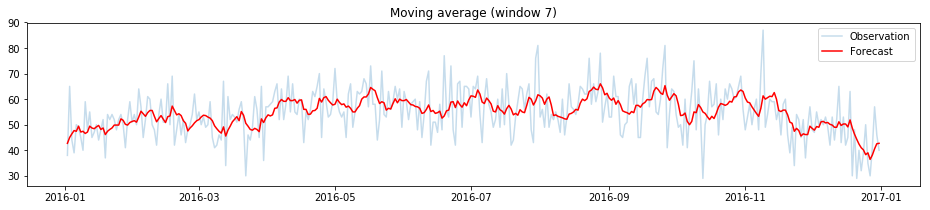

In [8]:
# rolling statistics
window = 7

prediction = ts.rolling(window = window, center = False).mean()[-len(test):] 
#rmse = 1 - sum((test - prediction) ** 2)/sum((test - test.mean()) ** 2)
mse = sum((test - prediction) ** 2)/len(test)
print('MSE: {:.4f}'.format(mse))

fig = plt.figure(figsize = (16,3))
t = range(len(test))
orig = plt.plot(test, color = 'C0', alpha = 0.25, label = 'Observation')
mean = plt.plot(test.index, prediction.values, color = 'red', label = 'Forecast')
plt.title('Moving average (window {})'.format(window))
plt.legend()
plt.show()

### [Model selection](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)

In [9]:
def ts_plots(TS, title = 'Time Series Analysis Plots', lags = None):
    """several useful visuals for time-series analysis"""

    plt.rcParams['figure.figsize'] = (16, 12)
    layout = (3, 2)
    ts_ax =   plt.subplot2grid(layout, (0, 0), colspan = 2)
    acf_ax =  plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax =   plt.subplot2grid(layout, (2, 0))
    pp_ax =   plt.subplot2grid(layout, (2, 1))

    TS.plot(ax = ts_ax)
    ts_ax.set_title(title)
    ts_ax.set_xticks([])

    smt.graphics.plot_acf(TS, lags = lags, ax = acf_ax, alpha = 0.5)
    acf_ax.set_title('Autocorrelation (ACF)')
    smt.graphics.plot_pacf(TS, lags = lags, ax = pacf_ax, alpha = 0.5)
    pacf_ax.set_title('Partial autocorrelation (PACF)')
    
    sm.qqplot(TS, line='s', ax = qq_ax)
    qq_ax.set_title('QQ Plot')
    scs.probplot(TS, sparams = (TS.mean(), TS.std()), plot = pp_ax)
    for ax in [pp_ax, qq_ax]:
        ax.get_lines()[0].set_marker('.')
        ax.get_lines()[0].set_markerfacecolor('C0')
        ax.get_lines()[0].set_markeredgecolor('C0')
        ax.get_lines()[0].set_markersize(10.0)
        ax.get_lines()[1].set_color('lightgray')

    plt.tight_layout()
    plt.show() 

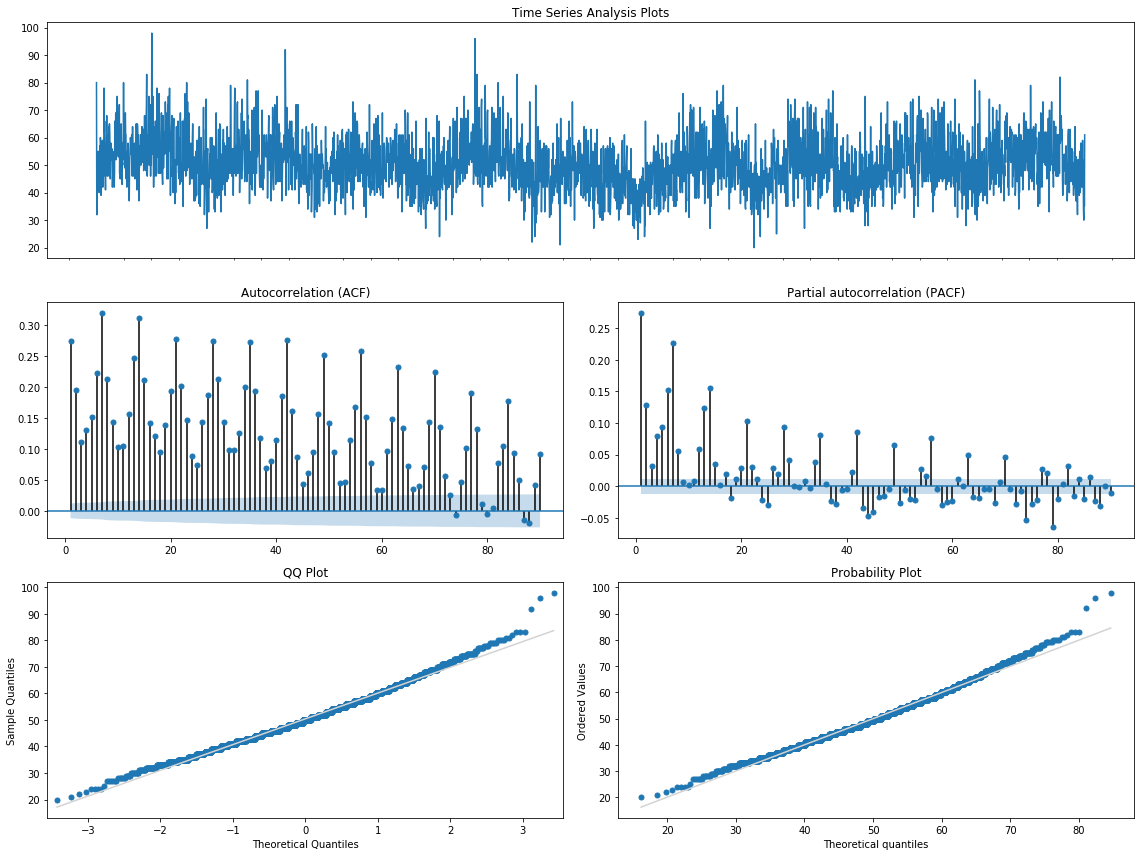

In [10]:
ts_plots(train, lags = range(1, 91))

There's a lot of serial correlation to explain.

Best stationarity result (-18.1112) with lag = 1
Most significant correlation (0.3216) with lag = 7


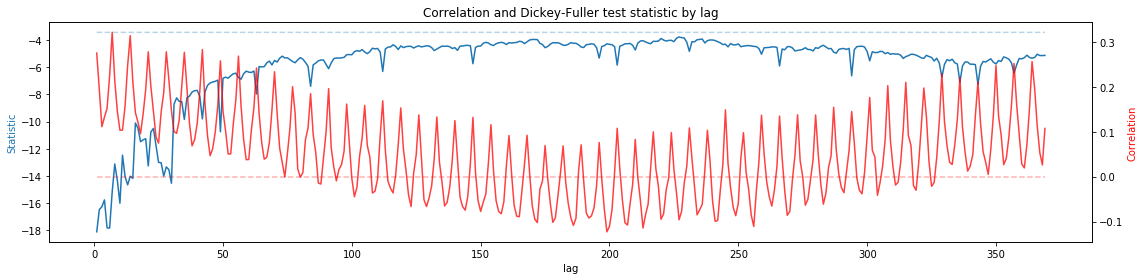

In [11]:
st = [] # find interesting lags
R = range(1, 370)

for lag in R:
    shifted = train.shift(lag)
    c = train[:-lag].corr(shifted)
    s = adfuller(((train - train.shift(lag)).dropna()).values)
    st.append((lag, c, s))

lag, _, statistics = sorted(st, key = lambda x: x[2][0])[0]
print('Best stationarity result ({:.4f}) with lag = {}'.format(statistics[0], lag))
lag, correlation, _ = sorted(st, key = lambda x: abs(x[1]))[-1]
print('Most significant correlation ({:.4f}) with lag = {}'.format(correlation, lag))

plt.rcParams['figure.figsize'] = (16, 4)
fig, ax1 = plt.subplots()
ax1.plot(R, [t[2][0] for t in st])
ax1.plot(R, [t[2][4]['1%'] for t in st], color = 'C0', linestyle = '--', alpha = 0.3)
ax1.set_title('Correlation and Dickey-Fuller test statistic by lag')
ax1.set_xlabel('lag')
ax1.set_ylabel('Statistic', color = 'C0')
ax2 = ax1.twinx()
ax2.plot(R, [t[1] for t in st], color = 'red', alpha = 0.75)
ax2.plot(R, [0 for t in st], color = 'red', linestyle = '--', alpha = 0.3)
ax2.set_ylabel('Correlation', color = 'red')

fig.tight_layout()
plt.show()

Notice the pairs of corresponding spikes at 7-day periods.

In [ ]:
# explore differentiation effect
tss = train.copy()
for x in sorted(st, key = lambda x: abs(x[1]), reverse = True):
    lag, cor, stats = x
    if abs(cor) > 0.25 and stats[0] < -6:
        print('Lag: {}  correlation: {:.4f}  statistic: {:.4f}'.format(lag, cor, stats[0]))
        tss = (tss - tss.shift(lag)).dropna()
        ts_plots(tss, title = 'Residuals after differentiation ({})'.format(lag), lags = range(lag, 90 + lag))

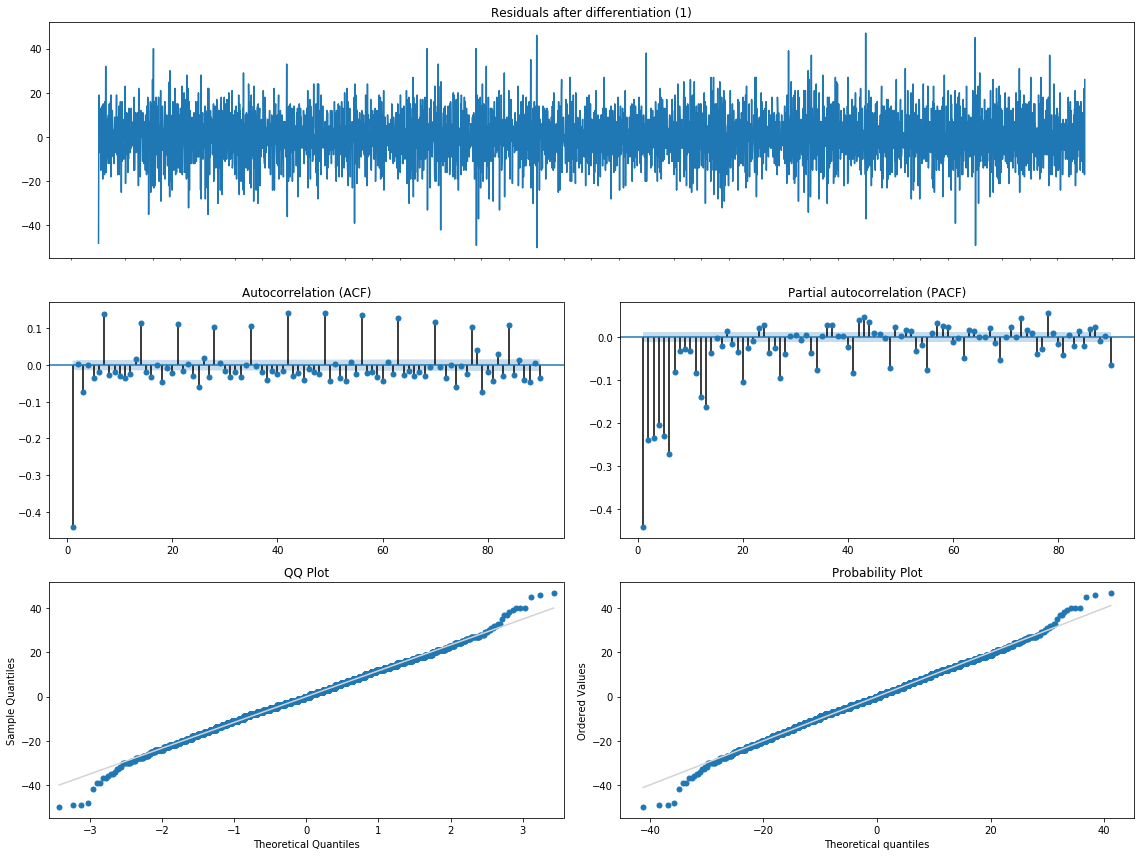

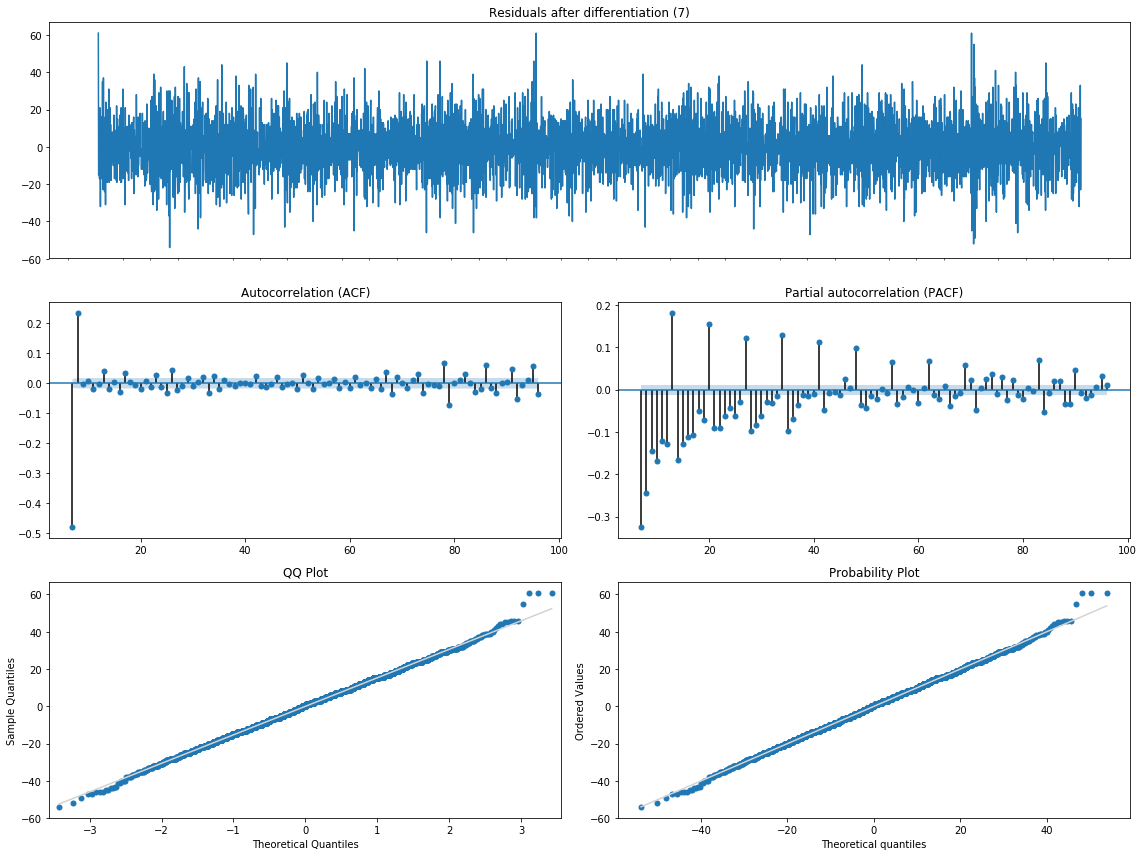

In [13]:
# pick based on exploration above
tss = train.copy()
for lag in [1, 7]:
    tss = (tss - tss.shift(lag)).dropna()
    ts_plots(tss, title = 'Residuals after differentiation ({})'.format(lag), lags = range(lag, 90 + lag))

### Decomposition

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

components = seasonal_decompose(train)
lag = len(train) - len(components.resid.dropna())
print('StatsModels proposed lag {}'.format(lag))

StatsModels proposed lag 6


In [15]:
def decompose(ts, freq = None):
    """extract and show trend and seasonal components from timeseries"""

    res = seasonal_decompose(ts, freq = freq)
    resid = res.resid.dropna()
    lag = len(ts) - len(resid)

    plt.rcParams['figure.figsize'] = (16, 6)
    layout = (2, 4)
    T = plt.subplot2grid(layout, (0, 0), colspan = 3)
    S = plt.subplot2grid(layout, (0, 3))
    R = plt.subplot2grid(layout, (1, 0), colspan = 4)

    T.plot(res.trend)
    T.set_title('Extracted trend')
    S.plot(range(lag), res.seasonal[:lag])
    S.set_title('Periodic component')
    R.plot(resid)
    R.set_title('Residuals')

    plt.tight_layout()
    plt.show()     

    return res

Let's experiment with some common intervals:


Using freq = (365, 'Year') for the next iteration:


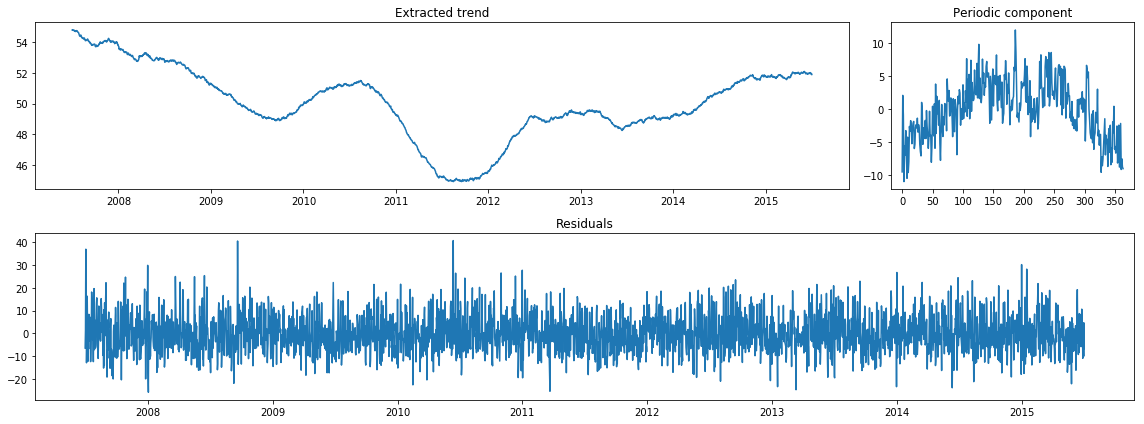


Using freq = (30, 'Month') for the next iteration:


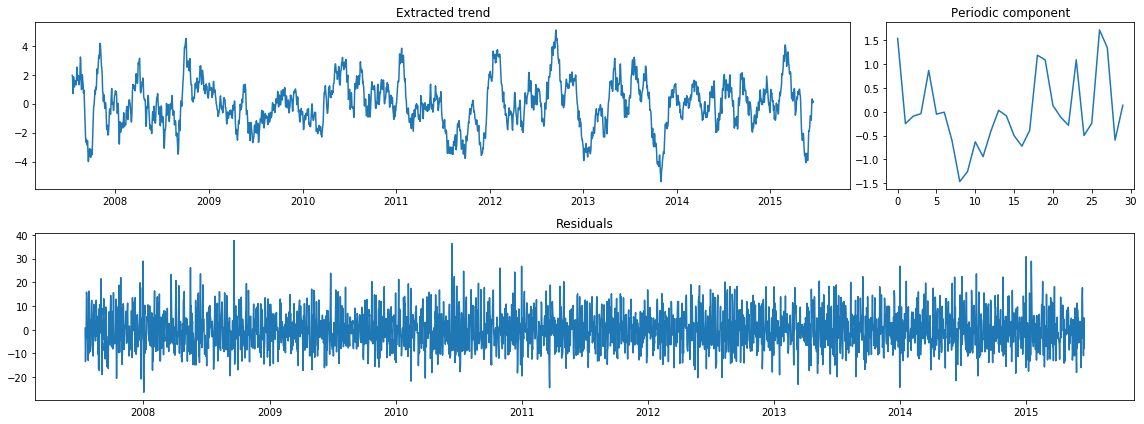


Using freq = (7, 'Week') for the next iteration:


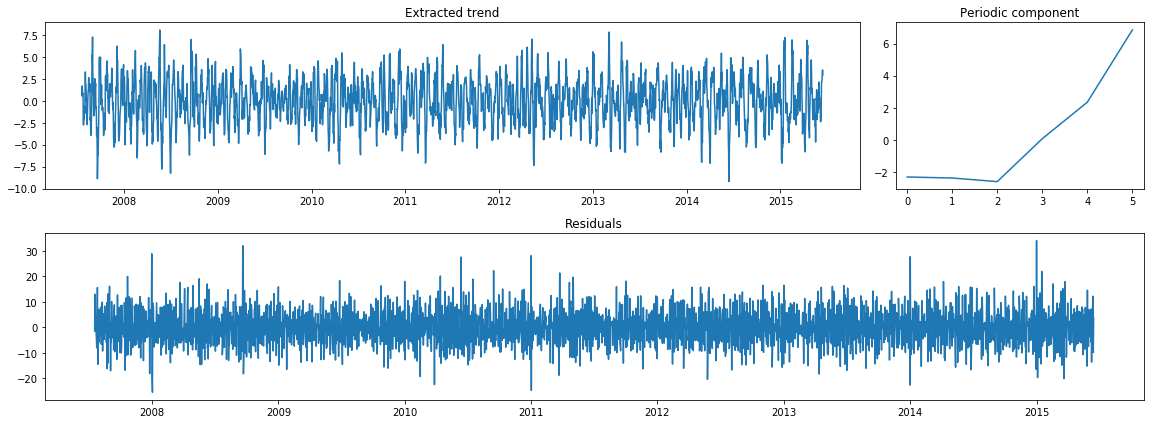

In [16]:
ts = train.copy()
trend = pd.Series(0, index = ts.index) 
seasonal = pd.Series(0, index = ts.index) 
for f in [(365, 'Year'), (30, 'Month'), (7, 'Week')]:
    print('\nUsing freq = {} for the next iteration:'.format(f))
    res = decompose(ts, freq = f[0])
    trend = (trend + res.trend).dropna().copy()
    seasonal = (seasonal + res.seasonal).dropna().copy()
    ts = res.resid.dropna().copy()

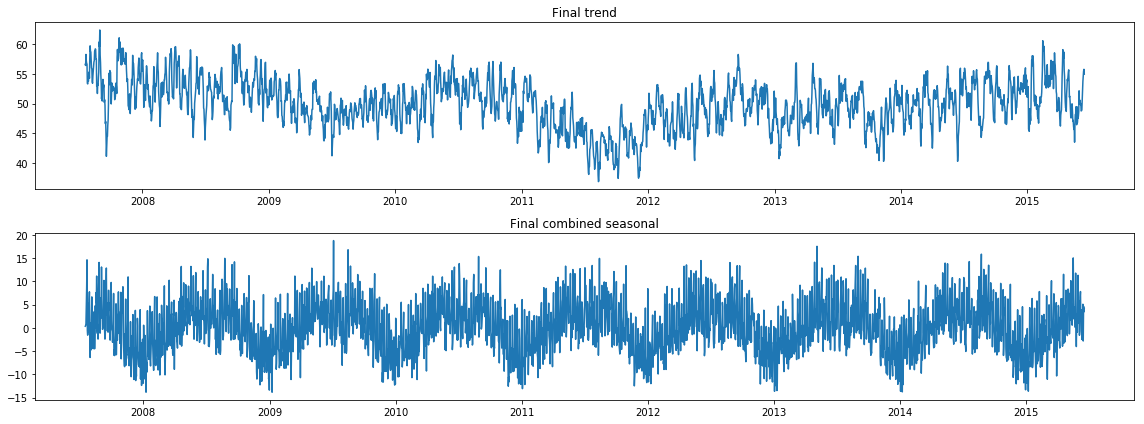

In [17]:
plt.rcParams['figure.figsize'] = (16, 6)
layout = (2, 1)
T = plt.subplot2grid(layout, (0, 0))
S = plt.subplot2grid(layout, (1, 0))
T.plot(trend)
T.set_title('Final trend')
S.plot(seasonal)
S.set_title('Final combined seasonal')
plt.tight_layout()
plt.show()     

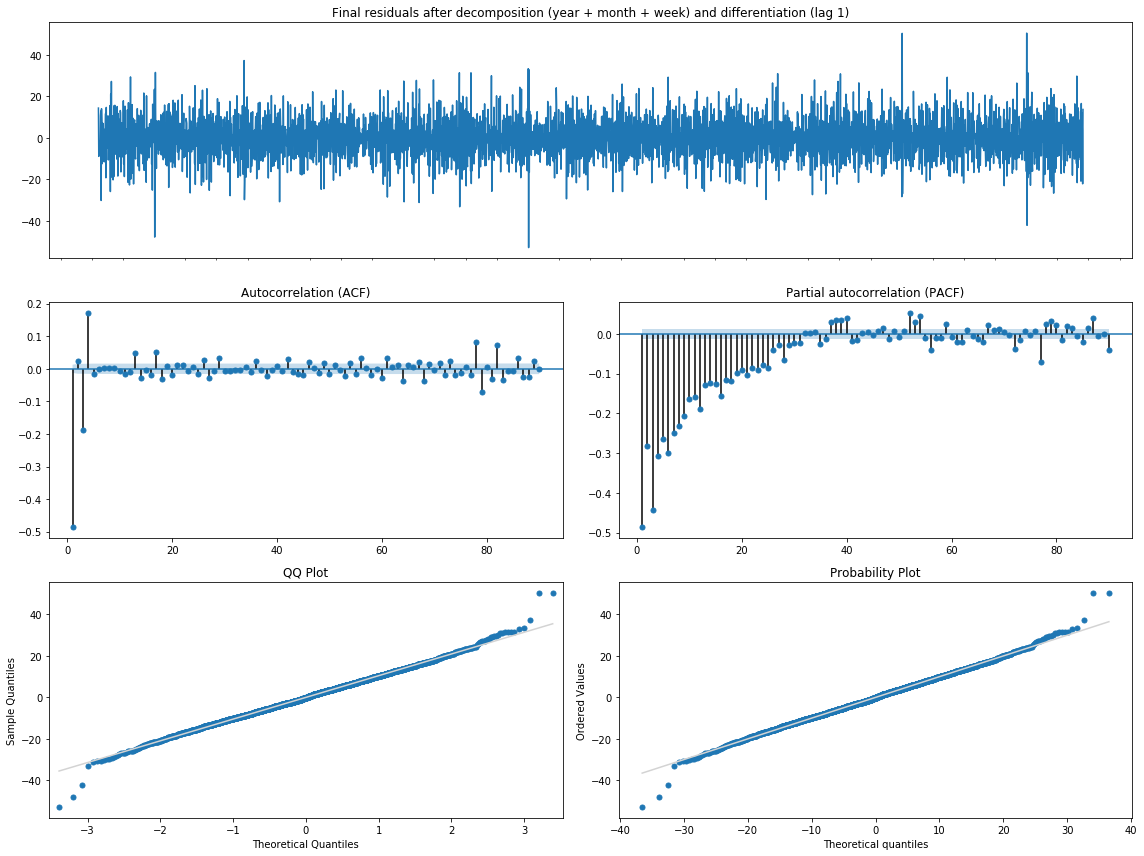

In [18]:
ts_plots((ts - ts.shift(1)).dropna(),
         title = 'Final residuals after decomposition (year + month + week) and differentiation (lag 1)',
         lags = range(1, 91))

## 1. Autoregressive Integrated Moving Average
Plots above suggest  [ARIMA](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis) model may be considered, it might not be able to capture all the serial correlation with acceptable number of parameters, but still give us an acceptable result.
The model defined as $$ \theta_{p}(L)(1 - L)^{d}x_{t} = \phi_{q}(L)w_{t}$$

where $\theta_{p}$ is autoregressive component of order $p$;
$\phi_{q}$ is moving-average component of order $q$;
$L$ is the lag operator (back shift), and $w$ is discrete white noise.

In [19]:
from statsmodels.tsa.arima_model import ARIMA

def show_result(order, s = 1):
    """plot rolling forecast vs. original with model update every s steps"""
    
    history = train.astype('float').tolist()
    prediction = []

    # updating model at every s steps
    for d in range(0, len(test), s):
        model = ARIMA(history, order = order).fit(disp = 0)
        n = min(s, len(test) - d)
        prediction = prediction + (model.forecast(steps = n)[0]).tolist()
        history = history + test[d:d + n].astype('float').tolist()

    prediction = pd.Series(prediction, index = test.index)
    #rmse = 1 - sum((test - prediction) ** 2)/sum((test - test.mean()) ** 2)
    mse = sum((test - prediction) ** 2)/len(test)
    print('MSE: {:.4f}'.format(mse))

    fig = plt.figure(figsize=(16,4))
    plt.plot(test, color = 'C0', alpha = 0.25, label = 'Observation')
    plt.plot(prediction, color = 'red', label = 'Forecast')
    plt.title('Rolling forecast with model update at every {}'.format('step' if s == 1 else '{} steps'.format(s)))
    plt.legend(loc = 'upper right')
    plt.show()

MSE: 76.2299


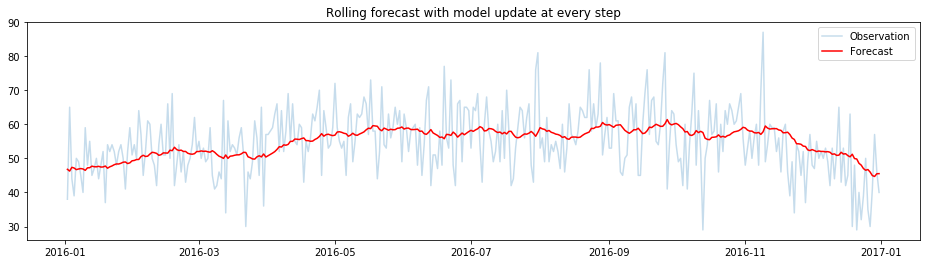

In [20]:
# let's see the simplest model: we just need differentiation (d = 1) and moving average (q = 1)
show_result((0, 1, 1))

The simplest model does not capture variability, only the trend, we would expect our $p$ and $q$ to be about 7 (or above) according to the ACF-PACF plots. (That would take some sweet time to compute.)

In [21]:
def find_best_model(timeseries, lim = (8, 2, 8)):
    """find best (p, d, q) combination whithin the specified range"""
    
    P, D, Q = lim
    best_aic = np.inf 
    best_order = None
    best_model = None
    for p in range(P): # order of autoregressive component
        for d in range(D): # order of integration (differentiation steps count)
            for q in range(Q): # order of moving-average component
                try:
                    model = ARIMA(timeseries.astype('float'), order = (p, d, q)).fit(disp = 0)
                    if best_aic > model.aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        best_model = model
                except:
                    continue # skip invertible and other "bad" combinations

    return best_aic, best_order, best_model

In [23]:
aic, order, model = find_best_model(train)
print('Best order: {} (aic: {:.4f})'.format(order, aic))
#show_result(order)

Best order: (7, 1, 7) (aic: 23268.8021)


## 2. LSTM
Another option to consider is RNN, [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) (Long Short Time Memory) in particular, a special kind of RNN, capable of learning long-term dependencies.

In [24]:
import tensorflow as tf
print(tf.__version__)

1.7.0


In [25]:
# network parameters
n_steps = 7
n_inputs = 1
n_neurons = 28
n_layers = 3
n_outputs = 1
n_iterations = 10000
batch_size = 256
learning_rate = 0.0001

In [91]:
tf.reset_default_graph()

In [92]:
# normalization
M = train.mean()
S = train.std()
#train_proc = ((train - M)/S).as_matrix()
#test_proc = ((train[-n_steps:].append(test) - M)/S).as_matrix()

# go as is
train_proc = train.as_matrix()
test_proc = train[-n_steps:].append(test).as_matrix()

In [93]:
# generate batches
def next_batch(n_steps, batch_size):
    size = n_steps * batch_size
    start = np.random.randint(0, train_proc.shape[0] - size)
    x = train_proc[start:start + size].reshape((batch_size, n_steps, 1))
    y = train_proc[start + 1:start + size + 1].reshape((batch_size, n_steps, 1))
    return x, y

In [94]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
Y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [95]:
# network architecture
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units = n_neurons, activation = tf.nn.relu)
                                 for layer in range(n_layers)]),
    output_size = n_outputs)

In [96]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

In [97]:
loss = tf.reduce_mean(tf.square(outputs - Y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
opt = optimizer.minimize(loss)

In [98]:
init = tf.global_variables_initializer()

In [99]:
local = tf.train.Saver()

In [100]:
# train network
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(n_iterations):
        X_batch, Y_batch = next_batch(n_steps, batch_size)
        sess.run(opt, feed_dict = { X: X_batch, Y: Y_batch })
        
        if i % 1000 == 0:
            print('Iteration: {:<8} MSE: {:.4f}'.format(i, loss.eval(feed_dict = { X: X_batch, Y: Y_batch })))
    print('Iteration: {:<8} MSE: {:.4f}'.format(i, loss.eval(feed_dict = { X: X_batch, Y: Y_batch })))
    local.save(sess, './rnn_model')


Iteration: 0        MSE: 2590.4949
Iteration: 1000     MSE: 130.4360
Iteration: 2000     MSE: 90.0765
Iteration: 3000     MSE: 84.8552
Iteration: 4000     MSE: 89.9681
Iteration: 5000     MSE: 84.1175
Iteration: 6000     MSE: 82.1597
Iteration: 7000     MSE: 80.9307
Iteration: 8000     MSE: 84.4841
Iteration: 9000     MSE: 81.7148
Iteration: 9999     MSE: 77.4463


INFO:tensorflow:Restoring parameters from ./rnn_model
MSE: 92.9010


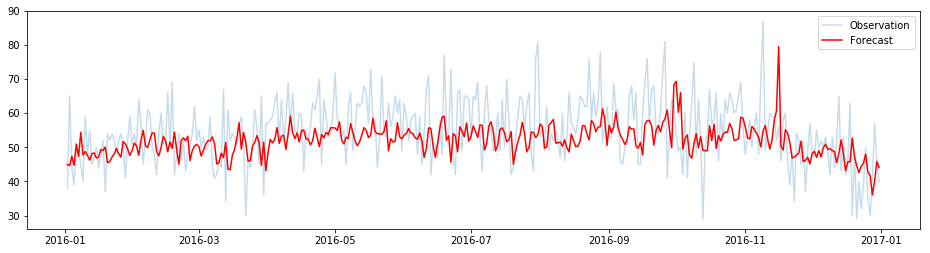

In [101]:
# rolling forcast
with tf.Session() as sess:
    local.restore(sess, './rnn_model')

    prediction = []
    for i in range(len(test)):
        X_test = test_proc[i:i + n_steps].reshape((1, n_steps, 1))
        Y_pred = sess.run(outputs, feed_dict = {X: X_test})
        #prediction.append(Y_pred.flatten()[-1] * S + M)
        prediction.append(Y_pred.flatten()[-1])
        
prediction = pd.Series(prediction, index = test.index)
#rmse = 1 - sum((test - prediction) ** 2)/sum((test - test.mean()) ** 2)
mse = sum((test - prediction) ** 2)/len(test)
print('MSE: {:.4f}'.format(mse))

fig = plt.figure(figsize=(16,4))
plt.plot(test, color = 'C0', alpha = 0.25, label = 'Observation')
plt.plot(prediction, color = 'red', label = 'Forecast')
plt.legend(loc = 'upper right')
plt.show()